# modeling and predicting

after performing our previous steps the data is now ready for modeling

# the previous steps

In [1]:
#import the relevant data packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
covid_out = pd.read_csv('COVID-19_Outcomes_by_Testing_Cohorts__Cases__Hospitalizations__and_Deaths_20240603.csv')
covid_waste = pd.read_csv('SARS-CoV-2_concentrations_measured_in_NYC_Wastewater_20240603.csv')

In [3]:
covid_out['specimen_date']=covid_out['specimen_date'].astype('str')
covid_out['specimen_date']= pd.to_datetime(covid_out['specimen_date'], errors= 'coerce')
covid_out= covid_out.drop('extract_date', axis=1)
covid_out= covid_out.rename(columns={'specimen_date':'sample_date',
                                        'Number_tested':'number_tested',
                                        'Number_confirmed':'number_confirmed',
                                        'Number_hospitalized':'number_hospitalized',})
covid_out=covid_out.dropna()

In [4]:
covid_waste=covid_waste.drop('Annotation', axis=1)
covid_waste=covid_waste.drop('Technology', axis=1)
covid_waste=covid_waste.drop('WRRF Abbreviation', axis=1)
covid_waste=covid_waste.drop('Test date', axis=1)

covid_waste['Sample Date']=covid_waste['Sample Date'].astype('str')
covid_waste['Sample Date']= pd.to_datetime(covid_waste['Sample Date'], errors= 'coerce')

covid_waste= covid_waste.rename(columns={'Sample Date':'sample_date',
                                        'WRRF Name':'collection_site',
                                        'Concentration SARS-CoV-2 gene target (N1 Copies/L) ':'concentration',
                                        'Per capita SARS-CoV-2 load (N1 copies per day per population)':'per_capita',
                                        'Population Served, estimated ':'est_pop'})
covid_waste=covid_waste.dropna()





In [5]:
covid_waste=covid_waste.drop('collection_site', axis=1)
covid_waste=covid_waste.drop('est_pop', axis=1)

In [6]:
mask1 = (covid_waste['sample_date'] > '2020-08-01') & (covid_waste['sample_date'] <= '2021-09-01')

covid_waste_short= covid_waste.loc[mask1]
print(covid_waste_short.head())

mask2 = (covid_out['sample_date'] > '2020-08-01') & (covid_out['sample_date'] <= '2021-09-01')
covid_out_short= covid_out.loc[mask2]
print(covid_out_short.head())

  sample_date  concentration  per_capita
0  2020-08-31          389.0    264000.0
1  2020-08-31         1204.0    444000.0
2  2020-08-31          304.0    169000.0
3  2020-08-31          940.0    574000.0
4  2020-08-31          632.0    233000.0
      sample_date  number_tested  number_confirmed  number_hospitalized  \
12693  2020-08-02             40                 1                    0   
12768  2020-08-02           1259                12                    4   
12835  2020-08-03             71                 1                    0   
12926  2020-08-02           3018                54                    8   
12932  2020-08-05            104                 2                    0   

       Number_deaths  
12693              0  
12768              0  
12835              0  
12926              0  
12932              0  


In [7]:
covid_time1= pd.merge(covid_waste_short, covid_out_short, on='sample_date')


/var/folders/mj/zknsgww149qf6c6r1yp4hz2h0000gn/T/ipykernel_64187/2932416337.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(covid_time1.corr(), annot=True)


<Axes: >

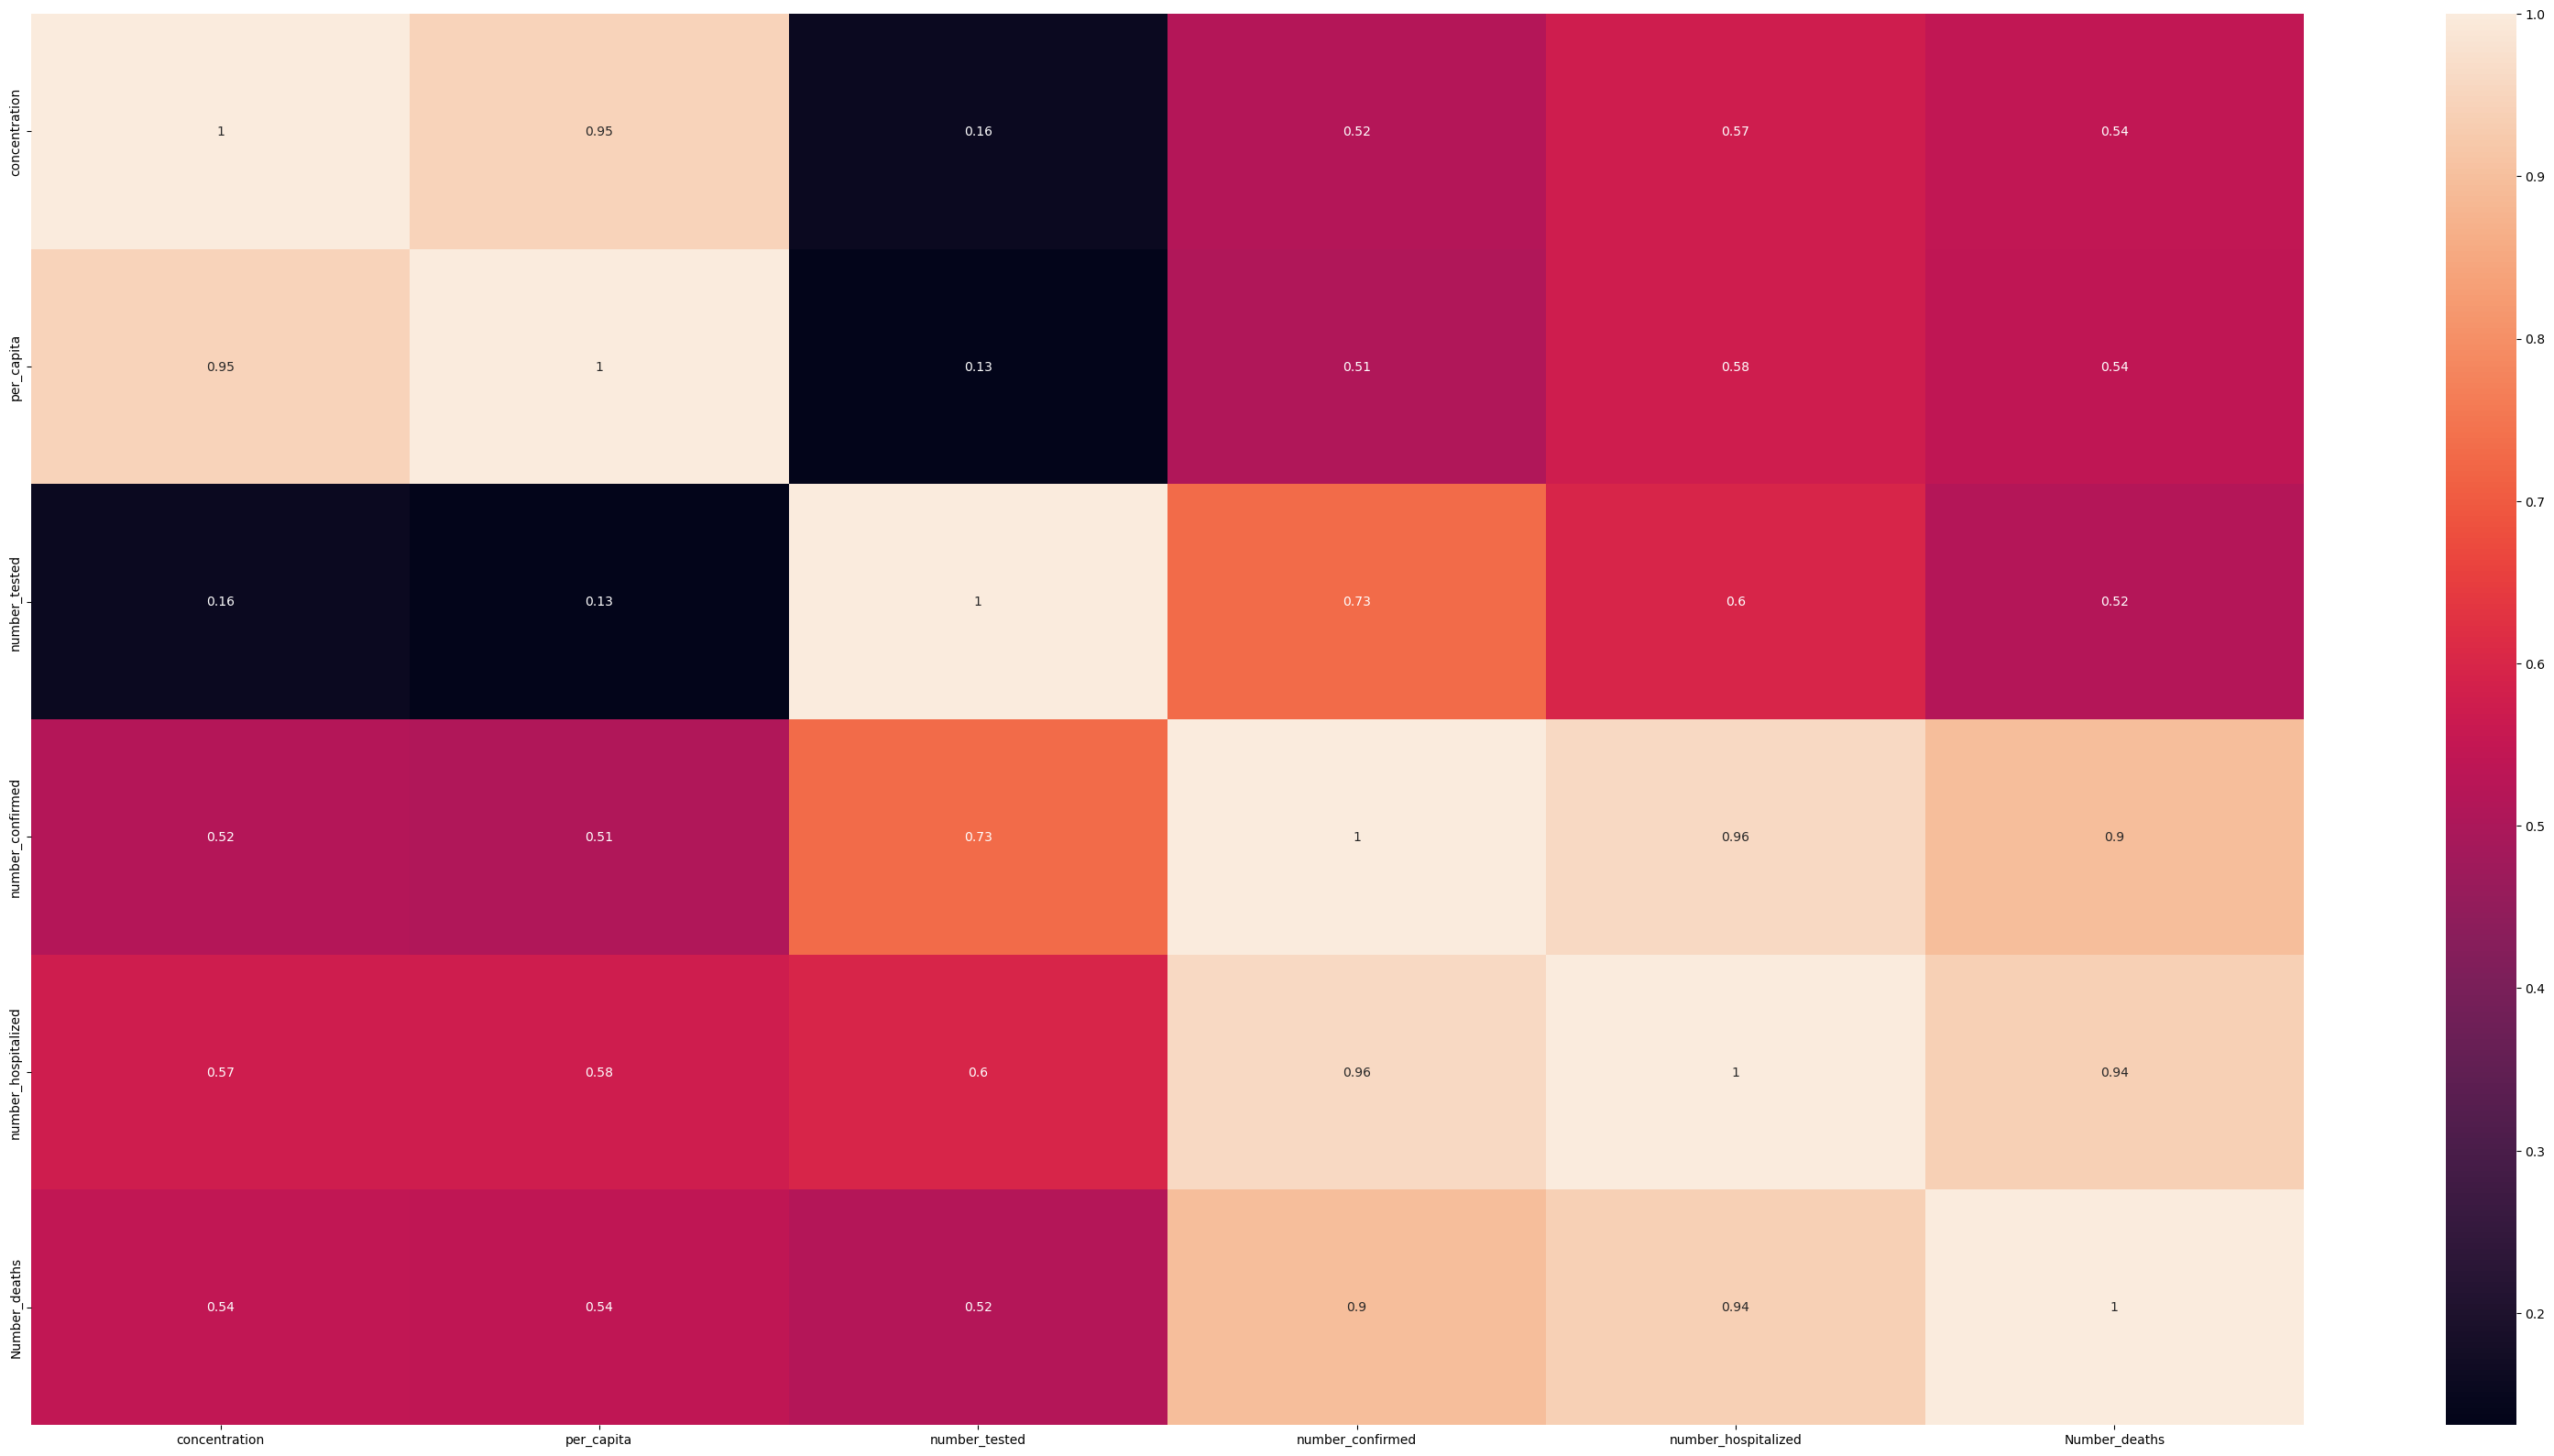

In [8]:
plt.figure(figsize=(40, 20))

sns.heatmap(covid_time1.corr(), annot=True)

In [9]:
correlation_matrix= covid_time1.corr(method='pearson')
print(correlation_matrix)

                     concentration  per_capita  number_tested  \
concentration             1.000000    0.945509       0.157940   
per_capita                0.945509    1.000000       0.131051   
number_tested             0.157940    0.131051       1.000000   
number_confirmed          0.515754    0.508627       0.730787   
number_hospitalized       0.573271    0.575328       0.598586   
Number_deaths             0.543993    0.540407       0.516646   

                     number_confirmed  number_hospitalized  Number_deaths  
concentration                0.515754             0.573271       0.543993  
per_capita                   0.508627             0.575328       0.540407  
number_tested                0.730787             0.598586       0.516646  
number_confirmed             1.000000             0.957624       0.896985  
number_hospitalized          0.957624             1.000000       0.938101  
Number_deaths                0.896985             0.938101       1.000000  


/var/folders/mj/zknsgww149qf6c6r1yp4hz2h0000gn/T/ipykernel_64187/2028093755.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix= covid_time1.corr(method='pearson')


## lets try testing the accuracy of per_capita

lets first try to transform the data to be on a similar scale
we will use Standard scaler to transform the data prior to modeling

In [10]:
scaler = StandardScaler()


scaler.fit_transform(covid_time1[['concentration']])



array([[-0.91239165],
       [-0.91239165],
       [-0.91239165],
       ...,
       [-0.73341316],
       [-0.73341316],
       [-0.73341316]])

In [11]:
scaler.fit_transform(covid_time1[['number_tested']])


array([[-1.95988827],
       [-1.38263169],
       [ 0.07988355],
       ...,
       [ 0.30132187],
       [ 0.30132187],
       [ 0.30132187]])

In [12]:
scaler.fit_transform(covid_time1[['number_confirmed']])


array([[-1.30612583],
       [-1.27373245],
       [-1.22357495],
       ...,
       [-0.73558433],
       [-0.73558433],
       [-0.73558433]])

In [13]:
scaler.fit_transform(covid_time1[['number_hospitalized']])


array([[-1.49999619],
       [-1.48635174],
       [-1.36355172],
       ...,
       [-0.89964053],
       [-0.89964053],
       [-0.89964053]])

In [14]:
scaler.fit_transform(covid_time1[['Number_deaths']])

array([[-1.18201216],
       [-1.18201216],
       [-1.18201216],
       ...,
       [-1.06649681],
       [-1.06649681],
       [-1.06649681]])

In [15]:
scaler.fit_transform(covid_time1[['per_capita']])

array([[-0.90795512],
       [-0.90795512],
       [-0.90795512],
       ...,
       [-0.68034281],
       [-0.68034281],
       [-0.68034281]])

once data has been transformed we can perform train_test_split on it
we want to see if an increase in virus, per_capita, will cause the number of confirmed, hospitalized or deaths to increase

In [16]:
covid_time1.head()

,sample_date,concentration,per_capita,number_tested,number_confirmed,number_hospitalized,Number_deaths
0,2020-08-31,389.0,264000.0,60,1,0,0
1,2020-08-31,389.0,264000.0,3561,32,1,0
2,2020-08-31,389.0,264000.0,12431,80,10,0
3,2020-08-31,389.0,264000.0,17473,145,18,0
4,2020-08-31,389.0,264000.0,18940,172,18,0


In [17]:


X= covid_time1[["number_tested", "number_confirmed", "number_hospitalized"]].values
y= covid_time1["per_capita"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



per_capita is placed on the y value becuase we want to use this value to predict if the other values in the X will increase or decrease as a result.

In [18]:
print('X_train : ')
print(X_train)
 
print('')
print('X_test : ')
print(X_test)
 
print('')
print('y_train : ')
print(y_train)
 
print('')
print('y_test : ')
print(y_test)

X_train : 
[[13101  1423   111]
 [ 9479  1674   171]
 [ 8786  1724   189]
 ...
 [10457  1561   129]
 [11365  2088   176]
 [10929  1818   146]]

X_test : 
[[10930  1842   167]
 [ 8226   217    19]
 [10967  2100   200]
 ...
 [10497  1646   146]
 [21941  2440   183]
 [21963  2902   226]]

y_train : 
[ 5300000. 18300000.  9480000. ...  6500000.  2780000.  7570000.]

y_test : 
[ 3310000.   566000.  8010000. ...  6780000.  7630000. 23500000.]


In [19]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
accuracy_score(y_test, y_pred)


0.005754831789773313

we appear to get low accuracy for this model lets try others if we can get better results

In [20]:

rfc = RandomForestClassifier(n_estimators=100,random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
accuracy_score(y_test, y_pred)



0.006538644004867886

In [21]:

abc = AdaBoostClassifier(n_estimators=100)
abc.fit(X_train, y_train)
y_pred = abc.predict(X_test)
accuracy_score(y_test, y_pred)



0.01041645180586209

In [22]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1,10):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

print('Test scores', test_scores)
print('')
print('Train scores', train_scores)


Test scores [0.02192611538540872, 0.022544914502588644, 0.020771023700006188, 0.020440997504176894, 0.019533425465646334, 0.018543346878158454, 0.017367628555516594, 0.015944390586002763, 0.014974938635754213]

Train scores [0.09245565181518152, 0.09213593234323432, 0.0926516089108911, 0.09268770627062706, 0.09315697194719472, 0.09363655115511552, 0.0944049092409241, 0.09510622937293729, 0.09579723597359736]


In [23]:
top_model = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
train_acc= knn.score(X_train, y_train)
test_acc = knn.score(X_test, y_test)
print(train_acc)

0.09579723597359736


maybe there is a hyperparameter we can tune to boost accuracy

In [24]:
max_k = np.argmax(train_scores)+1
print(max_k)

9


In [25]:
print(test_acc)

0.014974938635754213


In [26]:
max_k = np.argmax(test_scores)+1
print(max_k)

2


In [27]:
max_k = np.argmax(test_scores)+1
print(max_k)

2


In [28]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(X_test)
pl = confusion_matrix(y_test,y_pred)
print(confusion_matrix(y_test, y_pred))

[[15  0  0 ...  0  0  0]
 [ 0  7  1 ...  0  0  0]
 [ 0  0  8 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     69000.0       0.21      0.21      0.21        71
     81400.0       0.04      0.09      0.06        81
     83300.0       0.03      0.10      0.04        82
     86500.0       0.01      0.03      0.02        74
     91700.0       0.01      0.03      0.02        30
     95800.0       0.00      0.03      0.01        62
     97300.0       0.06      0.41      0.10        17
     97900.0       0.23      0.22      0.22        73
     99200.0       0.01      0.06      0.01        18
    104000.0       0.03      0.04      0.04        23
    105000.0       0.02      0.06      0.03        69
    106000.0       0.01      0.01      0.01        67
    107000.0       0.01      0.01      0.01       128
    111000.0       0.04      0.01      0.02        76
    121000.0       0.01      0.06      0.02        18
    122000.0       0.02      0.04      0.02        72
    125000.0       0.01      0.01      0.01       101
    127000.0       0.00    

/Users/douglasdomingo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/douglasdomingo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/douglasdomingo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [31]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.013712818359041406
Best Parameters: {'n_neighbors': 1}


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':np.arange(1,50)}
rf= RandomForestClassifier()
rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [33]:
print( "best score" + str(rf_cv.best_score_))
print("best parameters" + str(rf_cv.best_params_))

best score0.006188087582607809
best parameters{'n_estimators': 1}


even with hyperparameter tuning it looks like we still get poor accuracy
in the next part of the data analysis I analyzed the data with time series analysis in mind 